In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
jonathanoheix_face_expression_recognition_dataset_path = kagglehub.dataset_download('jonathanoheix/face-expression-recognition-dataset')

print('Data source import complete.')


100%|██████████| 121M/121M [02:20<00:00, 897kB/s]  

Extracting files...


Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Converting Image Data to Graph Data

In [4]:
!pip install torch_geometric

  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached frozenlist-1.7.0-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached propcache-0.3.2-cp313-cp313-win_amd64.whl.metadata (12 kB)
  Using cached yarl-1.20.1-cp313-cp313-win_amd64.whl.metadata (76 kB)
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ------------------ --------------------- 0.5/1.1 MB 497.9 kB/s eta 0:00:02
   ------------------ --------------------- 0.5/1.1 MB 497.9 kB/s eta 0:00:02
   --------------------------- ------------ 0.8/1.1 MB 509.6 kB/s eta 0:00:0

In [8]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement mediapipe (from versions: none)
ERROR: No matching distribution found for mediapipe


In [9]:
import os
import cv2
import torch
import numpy as np
import networkx as nx
from tqdm import tqdm
from torchvision import transforms
from torch_geometric.data import Data
import mediapipe as mp
from mediapipe.tasks.python.audio import audio_classifier

# Paths
IMAGE_DIR = '/kaggle/input/face-expression-recognition-dataset/images/train'  # Directory containing emotion images

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Initialize Mediapipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

def extract_landmarks(image):
    # Convert image to RGB for Mediapipe
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)

    if not results.multi_face_landmarks:
        return None

    landmarks = results.multi_face_landmarks[0]
    h, w, _ = image.shape
    coords = [(int(pt.x * w), int(pt.y * h)) for pt in landmarks.landmark]
    return np.array(coords)

def landmarks_to_graph(landmarks):
    G = nx.Graph()
    for i, (x, y) in enumerate(landmarks):
        G.add_node(i, x=float(x), y=float(y))

    # Connect sequential points for simplicity (you can define more specific topology if you want)
    for i in range(len(landmarks) - 1):
        G.add_edge(i, i + 1)

    # Optionally add some known facial structure edges (example below still works if the indices are valid)
    facial_structure_edges = [
        (33, 133),  # eyes outer corners
        (61, 291),  # mouth corners
        (1, 199),   # nose bridge area
    ]
    G.add_edges_from([e for e in facial_structure_edges if e[0] < len(landmarks) and e[1] < len(landmarks)])

    return G

def graph_to_data_object(G, label):
    x = torch.tensor([[G.nodes[n]['x'], G.nodes[n]['y']] for n in G.nodes], dtype=torch.float)
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

def process_dataset(image_folder, label_map):
    data_list = []
    for label_str, label_idx in label_map.items():
        folder = os.path.join(image_folder, label_str)
        if not os.path.exists(folder):
            print(f"Folder not found: {folder}")
            continue

        for img_name in tqdm(os.listdir(folder), desc=f"Processing {label_str}"):
            img_path = os.path.join(folder, img_name)
            image = cv2.imread(img_path)
            if image is None:
                print(f"Failed to load: {img_path}")
                continue

            landmarks = extract_landmarks(image)
            if landmarks is not None:
                G = landmarks_to_graph(landmarks)
                data = graph_to_data_object(G, label_idx)
                data_list.append(data)
    print(f"\n Total graph data objects created: {len(data_list)}")
    return data_list

# Label mapping based on Kaggle folder structure
label_map = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

# Process all data into graphs
graph_data = process_dataset(IMAGE_DIR, label_map)

# Save if needed
torch.save(graph_data, 'facial_expression_graphs.pt')


ModuleNotFoundError: No module named 'torch'

# Data Conversion

In [6]:
import torch

def pyg_to_cignn(data):
    # Directly use the sparse edge list without constructing a full adjacency matrix
    adj = data.edge_index.t().contiguous()  # Just the list of edges in (i, j) pairs
    features = data.x.numpy()  # Node features
    label = int(data.y.item())  # Scalar label for the graph

    # Return the graph data in a dictionary format
    graph_dict = {
        'adj': adj.numpy(),           # Edge list as an adjacency representation
        'feat': features,             # Node features as a NumPy array
        'label': label                # Label as a scalar
    }

    return graph_dict


In [7]:
converted_graphs = [pyg_to_cignn(d) for d in graph_data]

# Save as pickle to load into CI-GNN
import pickle

with open('cignn_face_data.pkl', 'wb') as f:
    pickle.dump(converted_graphs, f)


# Cloning CI-GNN Respo

In [8]:
! git clone https://github.com/ZKZ-Brain/CI-GNN.git

Cloning into 'CI-GNN'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 56 (delta 26), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 121.67 KiB | 1.69 MiB/s, done.
Resolving deltas: 100% (26/26), done.


## Setting-up New Directory

In [9]:
os.chdir('CI-GNN')

In [10]:
def load_face_expression_dataset(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    # Additional processing if necessary
    return data


In [21]:
import pickle
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, cohen_kappa_score,
    roc_auc_score, confusion_matrix
)
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv

import os
print("Current working dir:", os.getcwd())

# Dataset class using PyG
class CIGNNGraphDataset:
    def __init__(self, graph_list):
        self.graphs = []
        for graph in graph_list:
            data = Data(
                x=torch.tensor(graph['feat'], dtype=torch.float),  # [N, F]
                edge_index=torch.tensor(graph['adj'].T, dtype=torch.long),  # [2, E]
                y=torch.tensor([graph['label']], dtype=torch.long)  # [1]
            )
            self.graphs.append(data)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

def load_cignn_dataset(path='cignn_face_data.pkl', val_size=0.2, test_size=0.2, random_state=42):
    with open(path, 'rb') as f:
        graph_list = pickle.load(f)
    print(f" Loaded {len(graph_list)} graphs from {path}")

    labels = [g['label'] for g in graph_list]

    # First split into train+val and test
    temp_graphs, test_graphs = train_test_split(
        graph_list, test_size=test_size, stratify=labels, random_state=random_state
    )
    temp_labels = [g['label'] for g in temp_graphs]

    # Then split temp into train and val
    train_graphs, val_graphs = train_test_split(
        temp_graphs, test_size=val_size, stratify=temp_labels, random_state=random_state
    )

    train_dataset = CIGNNGraphDataset(train_graphs)
    val_dataset = CIGNNGraphDataset(val_graphs)
    test_dataset = CIGNNGraphDataset(test_graphs)

    return train_dataset, val_dataset, test_dataset

def get_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=1):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

# Model components
class GraphVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GraphVAE, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, latent_dim)

    def forward(self, x, edge_index):
        h = torch.relu(self.gcn1(x, edge_index))
        z = self.gcn2(h, edge_index)
        return z.mean(dim=0)  # Graph-level representation

class Classifier(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        return self.fc2(z)



Current working dir: /content/CI-GNN


 Loaded 26613 graphs from /content/cignn_face_data.pkl
Epoch 1/10 → Val Accuracy: 0.2583
Epoch 2/10 → Val Accuracy: 0.2583
Epoch 3/10 → Val Accuracy: 0.2583
Epoch 4/10 → Val Accuracy: 0.2583
Epoch 5/10 → Val Accuracy: 0.2583
Epoch 6/10 → Val Accuracy: 0.2583
Epoch 7/10 → Val Accuracy: 0.2583
Epoch 8/10 → Val Accuracy: 0.2583
Epoch 9/10 → Val Accuracy: 0.2583
Epoch 10/10 → Val Accuracy: 0.2583

 Test Results:
Accuracy: 0.2585008453879391
F1 Score: 0.058686797603053766
Cohen's Kappa: 0.0
ROC AUC: 0.5
Confusion Matrix:
 [[   0    0    0  700    0    0    0]
 [   0    0    0   75    0    0    0]
 [   0    0    0  736    0    0    0]
 [   0    0    0 1376    0    0    0]
 [   0    0    0  958    0    0    0]
 [   0    0    0  873    0    0    0]
 [   0    0    0  605    0    0    0]]


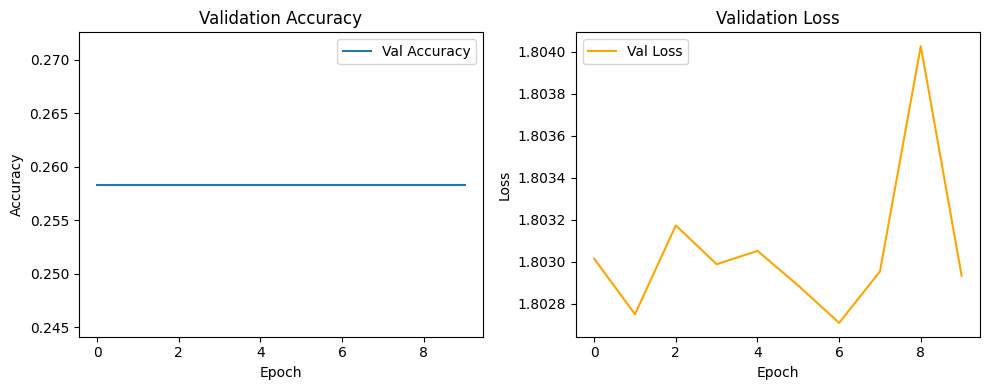

In [24]:

# Training & Evaluation
def train_and_evaluate(model_vae, model_cls, train_loader, val_loader, test_loader, epochs=10):
    optimizer = optim.Adam(list(model_vae.parameters()) + list(model_cls.parameters()), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    history = {'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        model_vae.train()
        model_cls.train()
        train_preds, train_labels = [], []

        for batch in train_loader:
            optimizer.zero_grad()
            z = model_vae(batch.x, batch.edge_index)
            logits = model_cls(z.unsqueeze(0))
            loss = criterion(logits, batch.y)
            loss.backward()
            optimizer.step()
            train_preds.append(logits.argmax(1).item())
            train_labels.append(batch.y.item())

        # Validation
        model_vae.eval()
        model_cls.eval()
        val_preds, val_labels, val_loss_total = [], [], 0
        with torch.no_grad():
            for batch in val_loader:
                z = model_vae(batch.x, batch.edge_index)
                logits = model_cls(z.unsqueeze(0))
                val_loss = criterion(logits, batch.y)
                val_loss_total += val_loss.item()
                val_preds.append(logits.argmax(1).item())
                val_labels.append(batch.y.item())

        val_acc = accuracy_score(val_labels, val_preds)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss_total / len(val_loader))
        print(f"Epoch {epoch+1}/{epochs} → Val Accuracy: {val_acc:.4f}")

    # Final test
    test_preds, test_labels, test_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            z = model_vae(batch.x, batch.edge_index)
            logits = model_cls(z.unsqueeze(0))
            test_preds.append(logits.argmax(1).item())
            test_labels.append(batch.y.item())
            test_probs.append(torch.softmax(logits, dim=1).squeeze(0).cpu().numpy())

    from sklearn.preprocessing import label_binarize

    # Binarize labels for ROC AUC
    n_classes = output_dim
    test_labels_bin = label_binarize(test_labels, classes=list(range(n_classes)))

    # Convert list of probs to array
    test_probs_arr = np.array(test_probs)

    print("\n Test Results:")
    print("Accuracy:", accuracy_score(test_labels, test_preds))
    print("F1 Score:", f1_score(test_labels, test_preds, average='macro'))
    print("Cohen's Kappa:", cohen_kappa_score(test_labels, test_preds))
    print("ROC AUC:", roc_auc_score(test_labels_bin, test_probs_arr, multi_class='ovr'))
    print("Confusion Matrix:\n", confusion_matrix(test_labels, test_preds))

    # Plot accuracy and loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['val_loss'], label='Val Loss', color='orange')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":

    train_ds, val_ds, test_ds = load_cignn_dataset('/content/cignn_face_data.pkl')
    train_loader, val_loader, test_loader = get_dataloaders(train_ds, val_ds, test_ds)

    first_sample = train_ds[0]
    actual_input_dim = first_sample.x.shape[1]
    actual_input_dim

    input_dim = actual_input_dim     # Make sure this matches your feature dimension
    hidden_dim = 2
    latent_dim = 2
    output_dim = 7     # Binary classification

    model_vae = GraphVAE(input_dim, hidden_dim, latent_dim)
    model_cls = Classifier(latent_dim, hidden_dim, output_dim)

    train_and_evaluate(model_vae, model_cls, train_loader, val_loader, test_loader)
    torch.save(model_vae.state_dict(), "graph_vae.pth")
    torch.save(model_cls.state_dict(), "classifier.pth")



In [54]:
import cv2
import torch
import torch.nn.functional as F
import mediapipe as mp
import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import io
import time

# Define GraphVAE class to match the expected state_dict keys
class GraphVAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GraphVAE, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, latent_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn1(x, edge_index))
        x = self.gcn2(x, edge_index)
        z = torch.mean(x, dim=0)  # Global mean pooling
        return z

# Define Classifier class
class Classifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Emotion labels (same as training)
emotion_dict = {
    0: 'Angry',
    1: 'Disgusted',
    2: 'Fearful',
    3: 'Happy',
    4: 'Neutral',
    5: 'Sad',
    6: 'Surprised'
}

# -------------------------
# Load trained models
# -------------------------
# ⚠️ Update these dimensions to match your trained models
input_dim = 2       # (x,y) landmarks
hidden_dim = 2      # Adjust if necessary
latent_dim = 2      # Adjust if necessary
output_dim = 7

model_vae = GraphVAE(input_dim, hidden_dim, latent_dim)
model_cls = Classifier(latent_dim, hidden_dim, output_dim)

# Load state dicts (adjust paths if necessary)
model_vae.load_state_dict(torch.load("graph_vae.pth", map_location="cpu"))
model_cls.load_state_dict(torch.load("classifier.pth", map_location="cpu"))
model_vae.eval()
model_cls.eval()

# -------------------------
# Mediapipe face mesh
# -------------------------
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=5,  # Allow multiple faces
    refine_landmarks=False,  # Set to True if using z-coordinate and input_dim=3
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# -------------------------
# Graph construction
# -------------------------
def get_face_edges():
    """Get edges from MediaPipe face mesh tesselation."""
    connections = list(mp_face_mesh.FACEMESH_TESSELATION)
    row = []
    col = []
    for i, j in connections:
        row.append(i)
        col.append(j)
        row.append(j)
        col.append(i)  # Undirected
    return torch.tensor([row, col], dtype=torch.long)

# Precompute edges (static for face mesh)
edge_index = get_face_edges()

def face_to_graph(landmarks, img_w, img_h):
    coords = []
    for lm in landmarks.landmark:
        coords.append([lm.x * img_w, lm.y * img_h])  # (x,y); add lm.z * img_h if input_dim=3 (normalize z if needed)
    x = torch.tensor(coords, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

# -------------------------
# Helper functions for Colab webcam
# -------------------------
def video_stream():
    js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(document.createElement('br'));

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640;
      captureCanvas.height = 480;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create' : preShow - preCreate,
              'show' : preCapture - preShow,
              'capture' : Date.now() - preCapture,
              'img' : result};
    }
    ''')
    display(js)

def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

def js_to_image(js_reply):
    """
    Params:
            js_reply: JavaScript object containing image from webcam
    Returns:
            img: OpenCV BGR image
    """
    # decode base64 image
    image_bytes = b64decode(js_reply.split(',')[1])
    # convert bytes to numpy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # decode numpy array into OpenCV BGR image
    img = cv2.imdecode(jpg_as_np, flags=1)

    return img

def bbox_to_bytes(bbox_array):
    """
    Params:
            bbox_array: Numpy array (pixels) containing rectangle to overlay on video feed.
    Returns:
          bytes: Base64 image byte string
    """
    # convert array into PIL image
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    # format bbox into png for return
    bbox_PIL.save(iobuf, format='png')
    # format return string
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

    return bbox_bytes

# For simplicity, we'll overlay the annotations directly on the frame and display as JPEG overlay.
# Start streaming video from webcam
video_stream()

# label for video
label_html = 'Capturing...'
# initialze overlay (empty for first frame)
overlay_image = ''

while True:
    js_reply = video_frame(label_html, overlay_image)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # Process the frame
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)

    emotion = "Unknown"  # Default
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            h, w, _ = frame.shape
            graph = face_to_graph(face_landmarks, w, h)

            with torch.no_grad():
                z = model_vae(graph.x, graph.edge_index)
                logits = model_cls(z.unsqueeze(0))
                pred = torch.argmax(F.softmax(logits, dim=1), dim=1).item()
                emotion = emotion_dict[pred]

            # Calculate bounding box from landmarks
            landmark_points = []
            for lm in face_landmarks.landmark:
                px = int(lm.x * w)
                py = int(lm.y * h)
                landmark_points.append((px, py))

            if landmark_points:
                x_coords, y_coords = zip(*landmark_points)
                min_x = max(0, min(x_coords) - 20)
                max_x = min(w, max(x_coords) + 20)
                min_y = max(0, min(y_coords) - 20)
                max_y = min(h, max(y_coords) + 20)

                # Draw rectangle around face
                cv2.rectangle(frame, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)

                # Put emotion text above the box
                text_y = min_y - 10 if min_y - 10 > 10 else min_y + 20
                cv2.putText(frame, emotion, (min_x, text_y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Update label with current emotion
    label_html = emotion

    # Convert annotated frame to data URL for overlay
    _, buffer = cv2.imencode('.jpg', frame)
    overlay_image = 'data:image/jpeg;base64,' + b64encode(buffer).decode('utf-8')

<IPython.core.display.Javascript object>